In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import BatchNormalization,Conv2D,MaxPool2D,AveragePooling2D,Dropout,Activation,Input,concatenate,Add,UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

In [99]:

def resolution_block(input_layer,n_convs,filters,kernel_size,padding = 'same',kernel_initializer = 'glorot_uniform',
                     batch_norm = False,dropout = None,activation = 'relu',strides = 1,name = '_'):
    '''
    Create a fully convolutional block with parameters
    inputs :
        n_convs : number of convolutional layers
        
    outputs:
        convs : 
    '''
    x = input_layer
    for i in range(n_convs):
        x = Conv2D(filters= filters,
                   kernel_size = kernel_size ,
                   strides= strides,
                   padding=padding,
                   kernel_initializer=kernel_initializer,
                   name = 'conv_'+str(i+1)+ '_' + name)(x)
        if batch_norm :
            x = BatchNormalization()(x)
        x = Activation(activation)(x)  
    if dropout : 
        x = Dropout(dropout)(x)
    
    #x = Add()([input_layer,x])
    
    return x



In [101]:

# def transition_down(input_layer):
#     x = input_layer
#     x = MaxPool2D(pool_size=(4))(x)
#     return x


def transition_up(input_layer,filters,target_size=0):
    
    x = input_layer
    size = input_layer.shape[1]
    #filters = input_layer.shape[-1]/2
    ratio = target_size/size
    x = UpSampling2D(size = int(ratio))(x)
    x = Conv2D(filters=filters,kernel_size=(1,1),padding = 'same')(x)
    
    return x
    

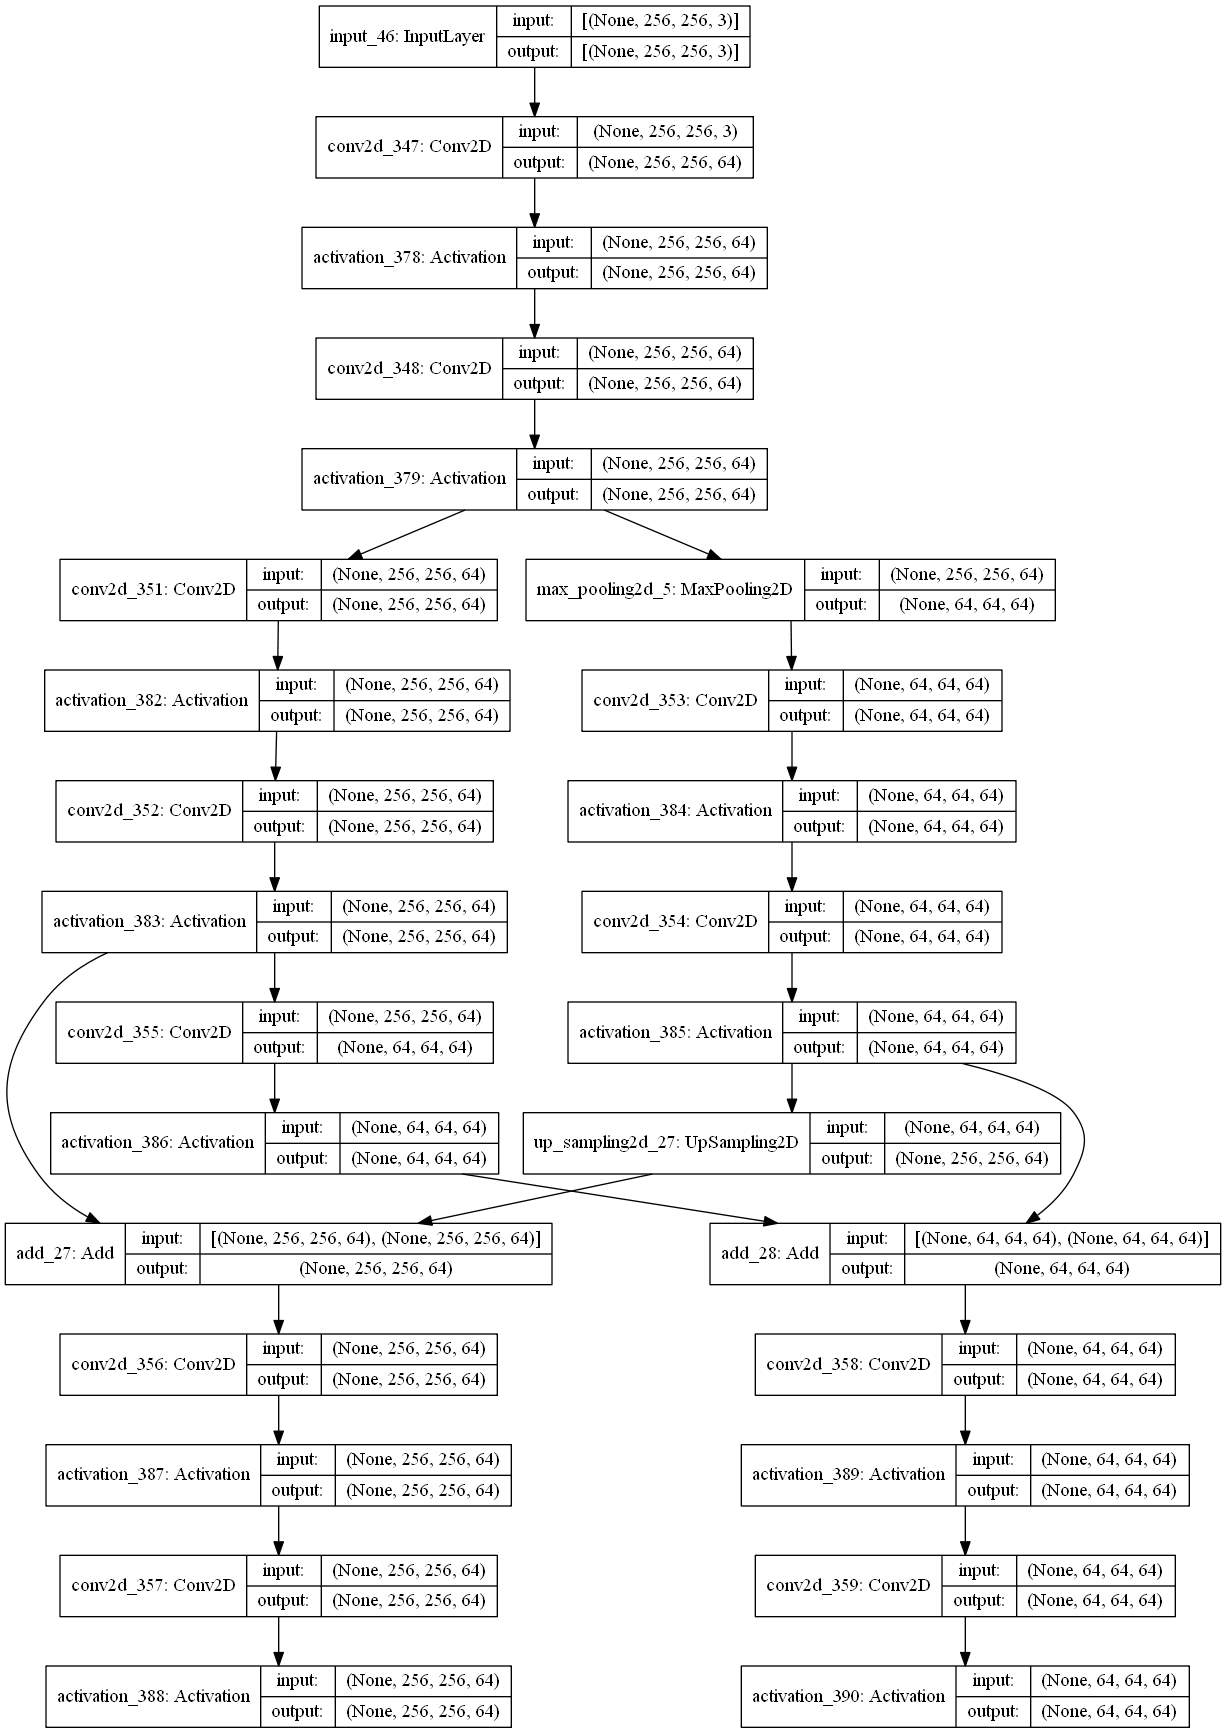

In [74]:

input_layer = Input(shape = (256,256,3))

# layers1 = resolution_block(input_layer,2,filters= 64,kernel_size=3,)
# down = transition_down(layers1)
# #down = resolution_block(layers1,1,filters=64,kernel_size=3,strides=4)
# layers2 = resolution_block(down,2,filters= 64,kernel_size=3)
# cont_1 = resolution_block(layers1,2,filters= 64,kernel_size=3)
# cont_2 = resolution_block(down,2,filters= 64,kernel_size=3)

# down2 = resolution_block(cont_1,1,filters=64,kernel_size=3,strides=4)

# up = transition_up(cont_2,target_size=256)
# ad = Add()([up,cont_1])

# ad2 = Add()([down2,cont_2])

# cont3 = resolution_block(ad,2,filters= 64,kernel_size=3)
# cont4 = resolution_block(ad2,2,filters= 64,kernel_size=3)


model = Model(inputs = input_layer,outputs= [cont3,cont4])


plot_model(model,show_shapes = True)

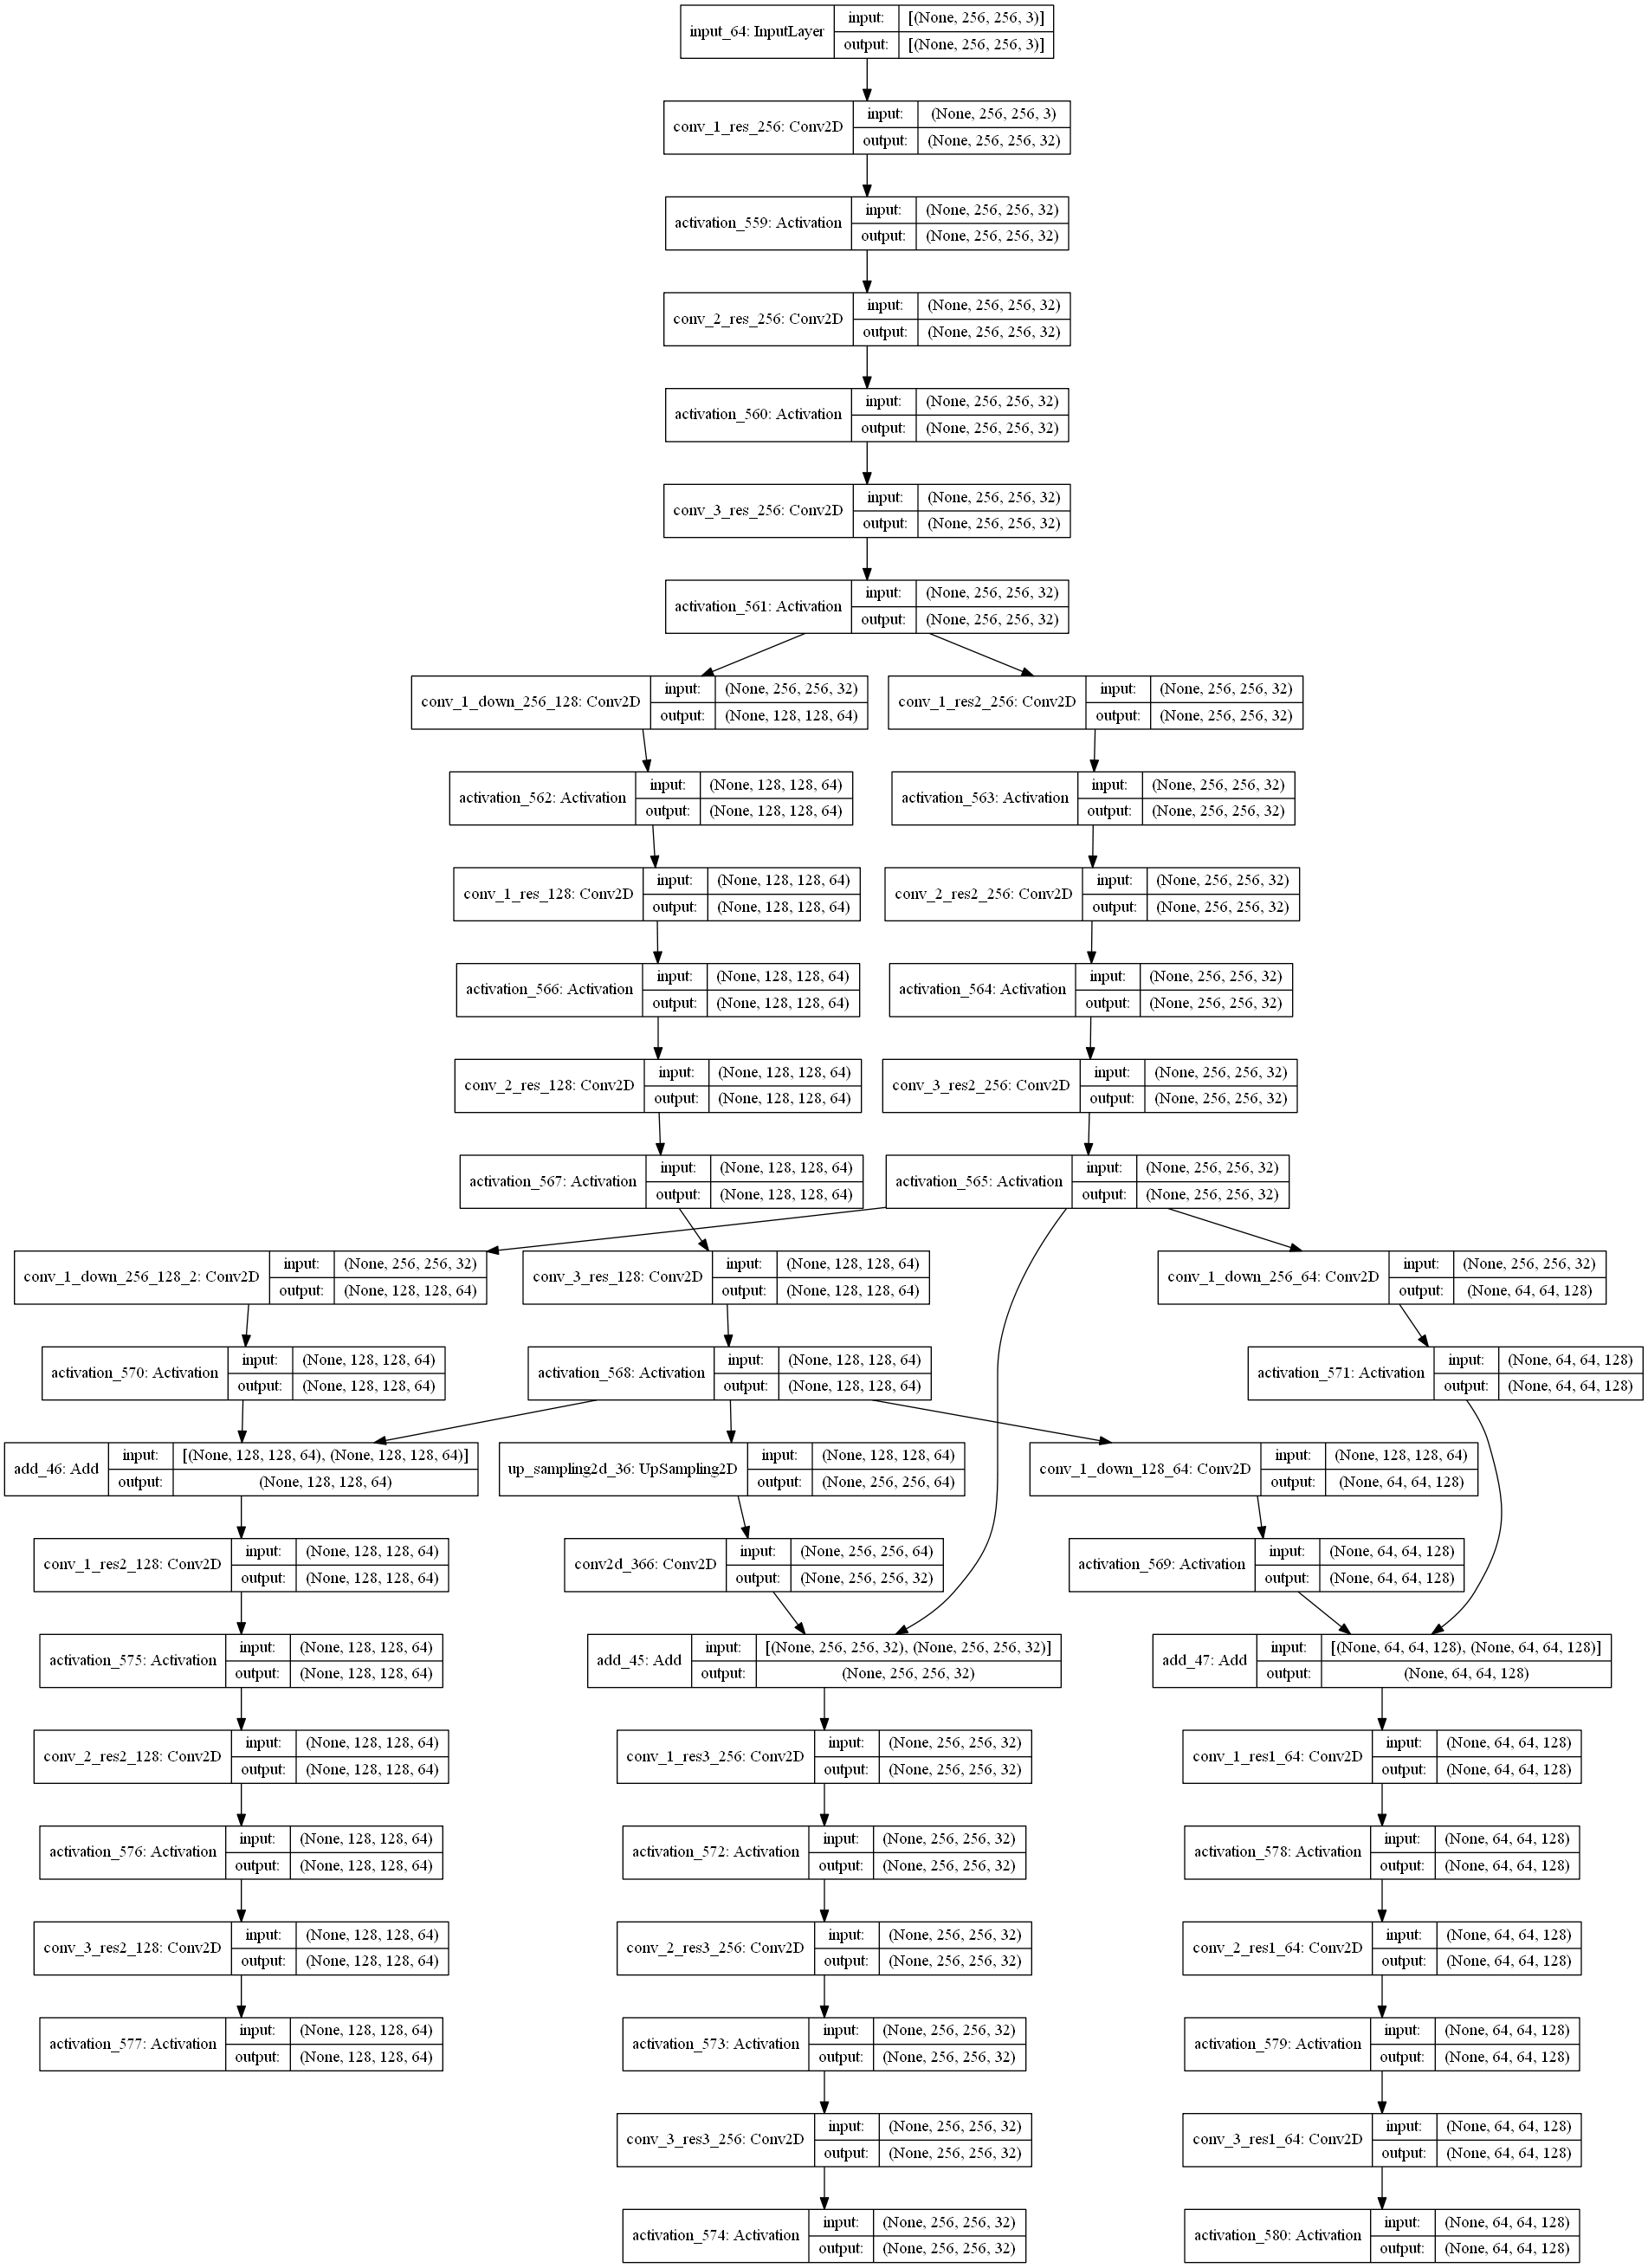

In [102]:

input_layer = Input(shape = (256,256,3))


high_res1 = resolution_block(input_layer,3,filters=32,kernel_size=3,name = 'res_256')
down_high_res1 = resolution_block(high_res1,1,filters=64,kernel_size=3,strides=2,name = 'down_256_128')

high_res2 = resolution_block(high_res1,3,filters=32,kernel_size=3,name ='res2_256')
low1_res1 = resolution_block(down_high_res1,3,filters=64,kernel_size=3,name = 'res_128')


down_low1_res1 = resolution_block(low1_res1,1,filters=128,kernel_size=3,strides=2,name = 'down_128_64')
up_low1_res1 = transition_up(low1_res1,32,256)

down_256_128 = resolution_block(high_res2,1,filters=64,kernel_size=3,strides=2,name = 'down_256_128_2')
down_256_64 = resolution_block(high_res2,1,filters=128,kernel_size=3,strides=4,name = 'down_256_64')



add1 = Add()([up_low1_res1,high_res2])
add2 = Add()([down_256_128,low1_res1])
add3 = Add()([down_256_64,down_low1_res1])


res256_3 = resolution_block(add1,3,filters=32,kernel_size=3,name= 'res3_256')
res128_2 = resolution_block(add2,3,filters=64,kernel_size=3,name= 'res2_128')
res64_1  = resolution_block(add3,3,filters=128,kernel_size=3,name= 'res1_64')


model = Model(inputs = input_layer,outputs= [res256_3,res128_2,res64_1])


plot_model(model,show_shapes = True)